In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
import h5py
from scipy import interpolate
from ccfj import GetStationPairs
import pandas as pd
import yaml
import geopandas as gp
import openpyxl
from openpyxl import load_workbook
from concurrent.futures import ThreadPoolExecutor

from scipy.interpolate import make_interp_spline
from scipy.stats import ks_2samp
from scipy.spatial import ConvexHull

In [2]:
import sys
sys.path.append(r'../tools_F-J/')
from toollib_standard import maplib
from toollib_standard import mathlib
from toollib_standard import filelib
from toollib_standard import stacklib
from toollib_standard import plotlib

In [3]:
with open('a-project_repar.yml', 'r', encoding='utf-8') as f:
    proj = yaml.load(f.read(), Loader=yaml.FullLoader)
name_project = proj['name']
#name_project = 'project_repartrition/output_repar_03-01/'               # Harmon server
name_project

'project_repartition_v3.0/output_repar_01-01/'

In [4]:
with open('0_config.yml', 'r', encoding='utf-8') as f:
    dir_config = yaml.load(f.read(), Loader=yaml.FullLoader)
dir_project_workspace = dir_config['dir_project_workspace']
dir_CC_workspace = dir_config['dir_CC_workspace']
print('dir_CC_workspace: ', dir_CC_workspace)
print('dir_project_workspace: ', dir_project_workspace)
dir_project = os.path.join(dir_project_workspace, name_project)
print('dir_project: ', dir_project)

dir_CC_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project_workspace:  /shdisk/rem2/Harmon/F-J/San/
dir_project:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/


In [5]:
filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [6]:
name_project_probes = info_basic['name_project_probes']
name_project_targets = info_basic['name_project_targets']
dir_project_probes = os.path.join(dir_project_workspace, name_project_probes)
dir_project_targets = os.path.join(dir_project_workspace, name_project_targets)
print('dir_project_probes: ', dir_project_probes)
print('dir_project_targets: ', dir_project_targets)

dir_project_probes:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/
dir_project_targets:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-02/


In [7]:
filename = dir_project_probes+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_probes = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project_probes+'Basic_info.npy'
info_basic_bi_probes = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

filename = dir_project_targets+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic_targets = yaml.load(f.read(), Loader=yaml.FullLoader)

filename = dir_project+'Basic_info.yml'
with open(filename, 'r', encoding='utf-8') as f:
    info_basic = yaml.load(f.read(), Loader=yaml.FullLoader)
filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

In [8]:
probes = info_basic_probes['key_subworks']
targets = info_basic_targets['key_subworks']
key_subworks = info_basic['key_subworks']

In [9]:
stalistname_all = info_basic['stalistname_all']
stainfo = pd.read_excel(stalistname_all)
nsta_all = len(stainfo.iloc[:,0])
StationPairs_all = GetStationPairs(nsta_all)
nPairs_all = int(len(StationPairs_all)/2)
stalist_all = stainfo['Station'].tolist()
lat_all = stainfo['latitude'].tolist() 
lon_all = stainfo['longitude'].tolist()

In [10]:
stalistname = dir_project_probes+ info_basic_probes['stalistname']
stainfo_probes = pd.read_excel(stalistname,sheet_name=None)
stalistname = dir_project_targets+ info_basic_targets['stalistname']
stainfo_targets = pd.read_excel(stalistname,sheet_name=None)

In [11]:
stalistname = dir_project+ info_basic['stalistname']
stainfo_all = pd.read_excel(stalistname,sheet_name=None)

stalistname = dir_project_probes+ info_basic_probes['stalistname']
stainfo_probes_all = pd.read_excel(stalistname,sheet_name=None)

stalistname = dir_project_targets+ info_basic_targets['stalistname']
stainfo_targets_all = pd.read_excel(stalistname,sheet_name=None)

In [12]:
stalistname = dir_project + 'subwork_location.xlsx'
loc_key = pd.read_excel(stalistname,sheet_name='location')
lat_key = loc_key['lat_centroid'].tolist()
lon_key = loc_key['lon_centroid'].tolist()

stalistname = dir_project_probes + 'subwork_location.xlsx'
loc_key_probes = pd.read_excel(stalistname,sheet_name='location')
key_probes = loc_key_probes['key_subwork'].tolist()
lat_key_probes = loc_key_probes['lat_centroid'].tolist()
lon_key_probes = loc_key_probes['lon_centroid'].tolist()

stalistname = dir_project_targets + 'subwork_location.xlsx'
loc_key_targets = pd.read_excel(stalistname,sheet_name='location')
key_targets = loc_key_targets['key_subwork'].tolist()
lat_key_targets = loc_key_targets['lat_centroid'].tolist()
lon_key_targets = loc_key_targets['lon_centroid'].tolist()

In [13]:
loc_probes = pd.read_excel(dir_project_probes + 'subwork_location.xlsx',sheet_name='location')
loc_targets = pd.read_excel(dir_project_targets + 'subwork_location.xlsx',sheet_name='location')

In [14]:
faults = np.load('clark_faults.npy', allow_pickle='TRUE').item()

In [15]:
dir_image = dir_project+'image_repick/'
if not os.path.exists(dir_image):
    os.makedirs(dir_image)
dir_disp_probes  = dir_project_probes + info_basic_probes['dir_disp'] 
print('dir_image: ', dir_image)
print('dir_disp: ', dir_disp_probes)

dir_image:  /shdisk/rem2/Harmon/F-J/San/project_repartition_v3.0/output_repar_01-01/image_repick/
dir_disp:  /shdisk/rem2/Harmon/F-J/San/project/output_FJSJ_17-01/autopick17-01//


In [16]:
probe_accept_all = info_basic_bi['probe_accept']

### Previous parameters

In [17]:
flag_err = info_basic['flag_err']
flag_pass = info_basic['flag_pass']
phase_mean = info_basic_bi['phase_mean']
ks_f_range = info_basic['ks_f_range']
print('flag_err: ', flag_err)
print('flag_pass: ', flag_pass)
print('ks_f_range: ', ks_f_range)

flag_err:  0.05
flag_pass:  0.3
ks_f_range:  [10, 15]


### Recluster

In [18]:
def extract_probes(key_subwork):
    global dir_project
    global dir_project_probes
    global dir_project_targets
    global probes
    global stainfo_targets

    stas = stainfo_targets[key_subwork]['Station'].tolist()
    # 生成sta的包络
    #hull_sta = ConvexHull(stainfo_targets[key_subwork][['Longitude','Latitude']])

    stas2key = [sta[1:3]+'-'+sta[3:] for sta in stas]
    probes_this = []
    for sta in stas2key:
        if sta in probes:
            probes_this.append(sta)
    return probes_this

In [19]:
def find_nearest(lon_this,lat_this,lon_all,lat_all):
    lon_all = np.array(lon_all)
    lat_all = np.array(lat_all)
    lon_all = lon_all.reshape(-1,1)
    lat_all = lat_all.reshape(-1,1)
    dist = np.sqrt((lon_all-lon_this)**2+(lat_all-lat_this)**2)
    min_dist = np.min(dist)
    index = np.where(dist==min_dist)[0][0]
    return index

In [20]:
def check_lat_lon(key_subwork):
    global stations_accept_all_new
    global lon_centroid_all_new
    global lat_centroid_all_new
    global stations_accept_all
    global lon_centroid_all
    global lat_centroid_all

    target = key_subwork.split('--')[0]
    stations_accept_all_new[key_subwork] = set(stations_accept_all[target])
    lon_centroid_all_new[key_subwork] = lon_centroid_all[target]
    lat_centroid_all_new[key_subwork] = lat_centroid_all[target]

In [21]:
def cluster_filter(target):
    global flag_err
    global flag_plot
    global dir_image
    global flag_pass
    global ds_probe_all
    global targets
    global probes
    global lon_all
    global lat_all
    global lon_sta
    global stations_accept_all
    global lon_centroid_all 
    global lat_centroid_all 
    global probe_accept_all

    # extract all disp
    probes_this = extract_probes(target)
    stations = set()
    for probe in probes_this:
        stations_this = [station for station in stainfo_probes[probe]['Station'].tolist()]
        stations = stations.union(set(stations_this))
        
    stations = list(stations)

    lon_this = []
    lat_this = []
    for probe in probes_this:
        lon_this.append(loc_probes['lon_centroid'][probes.index(probe)])
        lat_this.append(loc_probes['lat_centroid'][probes.index(probe)])
    # 读取全部autopick dispersion curves
    disp_all = {}
    for probe in probes_this:
        file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
        disp_all[probe] = disp[index,:]
    phase_this = [phase_mean[probe] for probe in probes_this]

    # find central probe and cluster based on it
    lon_centroid = np.mean(lon_this)
    lat_centroid = np.mean(lat_this)
    index = find_nearest(lon_centroid,lat_centroid,lon_this,lat_this)
    c_ref = phase_this[index]
    probe_ref = probes_this[index]
    
    phase_sort = np.sort(phase_this)
    index_phase = range(len(phase_sort))
    probe_accept = []
    phase_accept = []
    lon_accept = []
    lat_accept = []
    for probe in probes_this:
        if phase_mean[probe] >= c_ref*(1-flag_err) and phase_mean[probe] <= c_ref*(1+flag_err):
            probe_accept.append(probe)
            lon_accept.append(loc_probes['lon_centroid'][probes.index(probe)])
            lat_accept.append(loc_probes['lat_centroid'][probes.index(probe)])
            phase_accept.append(phase_mean[probe])

    # ks analysis
    lon_centroid = np.mean(lon_accept)
    lat_centroid = np.mean(lat_accept)
    index = find_nearest(lon_centroid,lat_centroid,lon_accept,lat_accept)
    probe_ref = probe_accept[index]

    f_sample = np.linspace(ks_f_range[0],ks_f_range[1],200,endpoint=False)
    c_pick = {}
    for probe in probes_this:
        c_pick[probe] = []
        file_ds = dir_project_probes  + info_basic_probes['dir_disp'] + 'autopick_'+probe+'.txt'
        disp = np.loadtxt(file_ds,delimiter=',')
        index = np.where((disp[:,0]>=ks_f_range[0]) & (disp[:,0]<=ks_f_range[1]))[0]
        disp = disp[index,:]
        f_this = disp[:,0]
        c_this = disp[:,1]
        # 生成插值函数,可以外推
        #f = interpolate.interp1d(f_this,c_this,kind='cubic')
        f = interpolate.interp1d(f_this,c_this,kind='cubic',fill_value='extrapolate')
        c_pick[probe] = f(f_sample)

    f_pick_ref = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,0]
    c_pick_ref0 = np.loadtxt(dir_disp_probes+'autopick_'+probe_ref+'.txt',delimiter=',')[:,1]
    #f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic')
    f = interpolate.interp1d(f_pick_ref,c_pick_ref0,kind='cubic',fill_value='extrapolate')
    c_pick_ref = f(f_sample)

    ks_p_values = []
    ks_statistic = []
    for probe in probe_accept:
        ks_p_values.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[1])
        ks_statistic.append(ks_2samp(c_pick[probe]-np.mean(c_pick[probe]),c_pick_ref-np.mean(c_pick_ref))[0])

    # original partition
    sta_original = set()
    for probe in probes_this:
        sta_original = sta_original.union(set(stainfo_probes[probe]['Station'].tolist()))
    sta_original = list(sta_original)
    lon_original = []
    lat_original = []
    for sta in sta_original:
        index = stalist_all.index(sta)
        lon_original.append(lon_all[index])
        lat_original.append(lat_all[index])


    index_pass = np.array(ks_statistic)<flag_pass
    probe_pass = np.array(probe_accept)[index_pass]
    lon_pass = np.array(lon_accept)[index_pass]
    lat_pass = np.array(lat_accept)[index_pass]
    ks_statistic_pass = np.array(ks_statistic)[index_pass]

    # new partition
    sta_pass = set()
    lon_pass_all = []
    lat_pass_all = []
    for probe in probe_pass:
        sta_pass = sta_pass.union(set(stainfo_probes[probe]['Station'].tolist()))
    sta_pass = list(sta_pass)
    for sta in sta_pass:
        index = stalist_all.index(sta)
        lon_pass_all.append(lon_all[index])
        lat_pass_all.append(lat_all[index])
    stations_accept_all[target] = sta_pass
    lon_centroid_all[target] = np.mean(lon_pass_all)
    lat_centroid_all[target] = np.mean(lat_pass_all)
    

    if flag_plot == 1:
        fig = plt.figure(figsize=(18,15))
        ax = fig.add_subplot(332)
        ax.scatter(index_phase,phase_sort,c='k',s=20)
        ax.axhline(y=c_ref,color='b',ls='--',label='central mean')
        ax.axhline(y=c_ref*(1-flag_err),color='r',ls='--',label='tolerance range')
        ax.axhline(y=c_ref*(1+flag_err),color='r',ls='--')
        ax.set_xlabel('probe index')
        ax.set_ylabel('phase velocity (km/s)')
        ax.legend()

        ax = fig.add_subplot(331)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_this,lat_this,c=phase_this,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        #设置colorbar范围
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target + ' mean phase velocity distribution')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()
        """
        print('phase_max: ', max(phase_this))
        print('phase_min: ', min(phase_this))
        print('phase_bar: ', max(phase_this)-min(phase_this))
        print('phase_percent: ', (max(phase_this)-min(phase_this))/np.mean(phase_this)*100, '%')
        """
        ax = fig.add_subplot(333)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_accept,lat_accept,c=phase_accept,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        im.set_clim(vmin=min(phase_this),vmax=max(phase_this))
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target + ' mean phase velocity distribution after filter')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        fig.colorbar(im, ax=ax)
        ax.legend()

        ax = fig.add_subplot(334)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_accept,lat_accept,c=ks_statistic,s=20,cmap='jet')
        ax.scatter(lon_centroid,lat_centroid,c='k',s=60,marker='*',label = 'centroid')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        plt.colorbar(im, ax=ax)
        im.set_clim(vmin=flag_pass,vmax=flag_pass*2)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' K-S value distribution')

        ax = fig.add_subplot(335)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        im = ax.scatter(lon_pass,lat_pass,c=ks_statistic_pass,s=20,cmap='jet')
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        im.set_clim(vmin=flag_pass,vmax=flag_pass*2)
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' K-S value distribution after filter')
        plt.colorbar(im, ax=ax)

        ax = fig.add_subplot(336)
        ax.scatter(lon_all,lat_all,c='k',s=1)
        for i in range(len(faults)):
            ax.plot(faults['clark'+str(i+1)]['lon'], faults['clark'+str(i+1)]['lat'], 'k--',lw=1)
        
        ax.scatter(lon_this,lat_this,c = 'g',s=20,label = 'original partitions')
        # 画空心圆
        ax.scatter(lon_pass_all,lat_pass_all,c = None,s=30,marker='o',edgecolors='r',label = 'new partitions')
        ax.set_xlabel('Longitude')
        ax.set_ylabel('Latitude')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(target+' partition comparison')
        ax.legend()

        ax = fig.add_subplot(325)
        for probe in probes_this:
            if probes_this.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.',label='all probes')
            ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.')
        ax.plot(f_sample,c_pick_ref,'r',lw=2,label='central probe')
        ax.set_xlabel('frequency (Hz)')
        ax.set_ylabel('phase velocity (km/s)')
        ax.set_title(target+" all probes' dispersion curves")
        ax.legend()
        ax.set_xlim(ks_f_range[0],ks_f_range[1])
        ax.set_ylim(0.2,2)

        ax = fig.add_subplot(326)
        for probe in probes_this:
            if probes_this.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.',label='all probes')
            ax.scatter(f_sample,c_pick[probe],c='k',s=1,marker='.')
        probe_pass = list(probe_pass)
        for probe in probe_pass:
            if probe_pass.index(probe) == 0:
                ax.scatter(f_sample,c_pick[probe],c='g',s=2,marker='.',label='picked probes')
            ax.scatter(f_sample,c_pick[probe],c='g',s=2,marker='.')
        ax.plot(f_sample,c_pick_ref,'r',lw=2,label='central probe')
        ax.set_xlabel('frequency (Hz)')
        ax.set_ylabel('phase velocity (km/s)')
        ax.set_title(target+" dispersion curves accepted")
        ax.set_xlim(ks_f_range[0],ks_f_range[1])
        ax.set_ylim(0.2,2)
        ax.legend()

        plt.tight_layout()
        plt.savefig(dir_image+'K-S_filter_'+target+'.png',dpi=100)
        #plt.close()
    print('cluster_filter: ', target + ' finished, '+str(targets.index(target)+1)+'/'+str(len(targets)))
    probe_accept_all[target] = probe_pass

In [33]:
ds_probe_all = {}
for probe in info_basic_probes['key_subworks']:
    file_ds = dir_project_probes  + info_basic_probes['dir_ds'] + 'ds_'+probe+'.h5'
    ds = h5py.File(file_ds,'r')
    ds_probe_all[probe] = ds['ds_remove'][0]
    ds.close()

In [345]:
nums_repick =[681]
key_subworks = []
for num in nums_repick:
    tag = str(num)
    key_subwork0 = [key_subwork for key_subwork in info_basic['key_subworks'] if tag == key_subwork[-len(str(tag)):]][0]
    key_subworks.append(key_subwork0)
key_subworks

['52-18--681']

/tmp/ipykernel_76971/224813944.py:248: UserWarning: tight_layout not applied: number of columns in subplot specifications must be multiples of one another.
  plt.tight_layout()


cluster_filter:  52-18 finished, 766/768


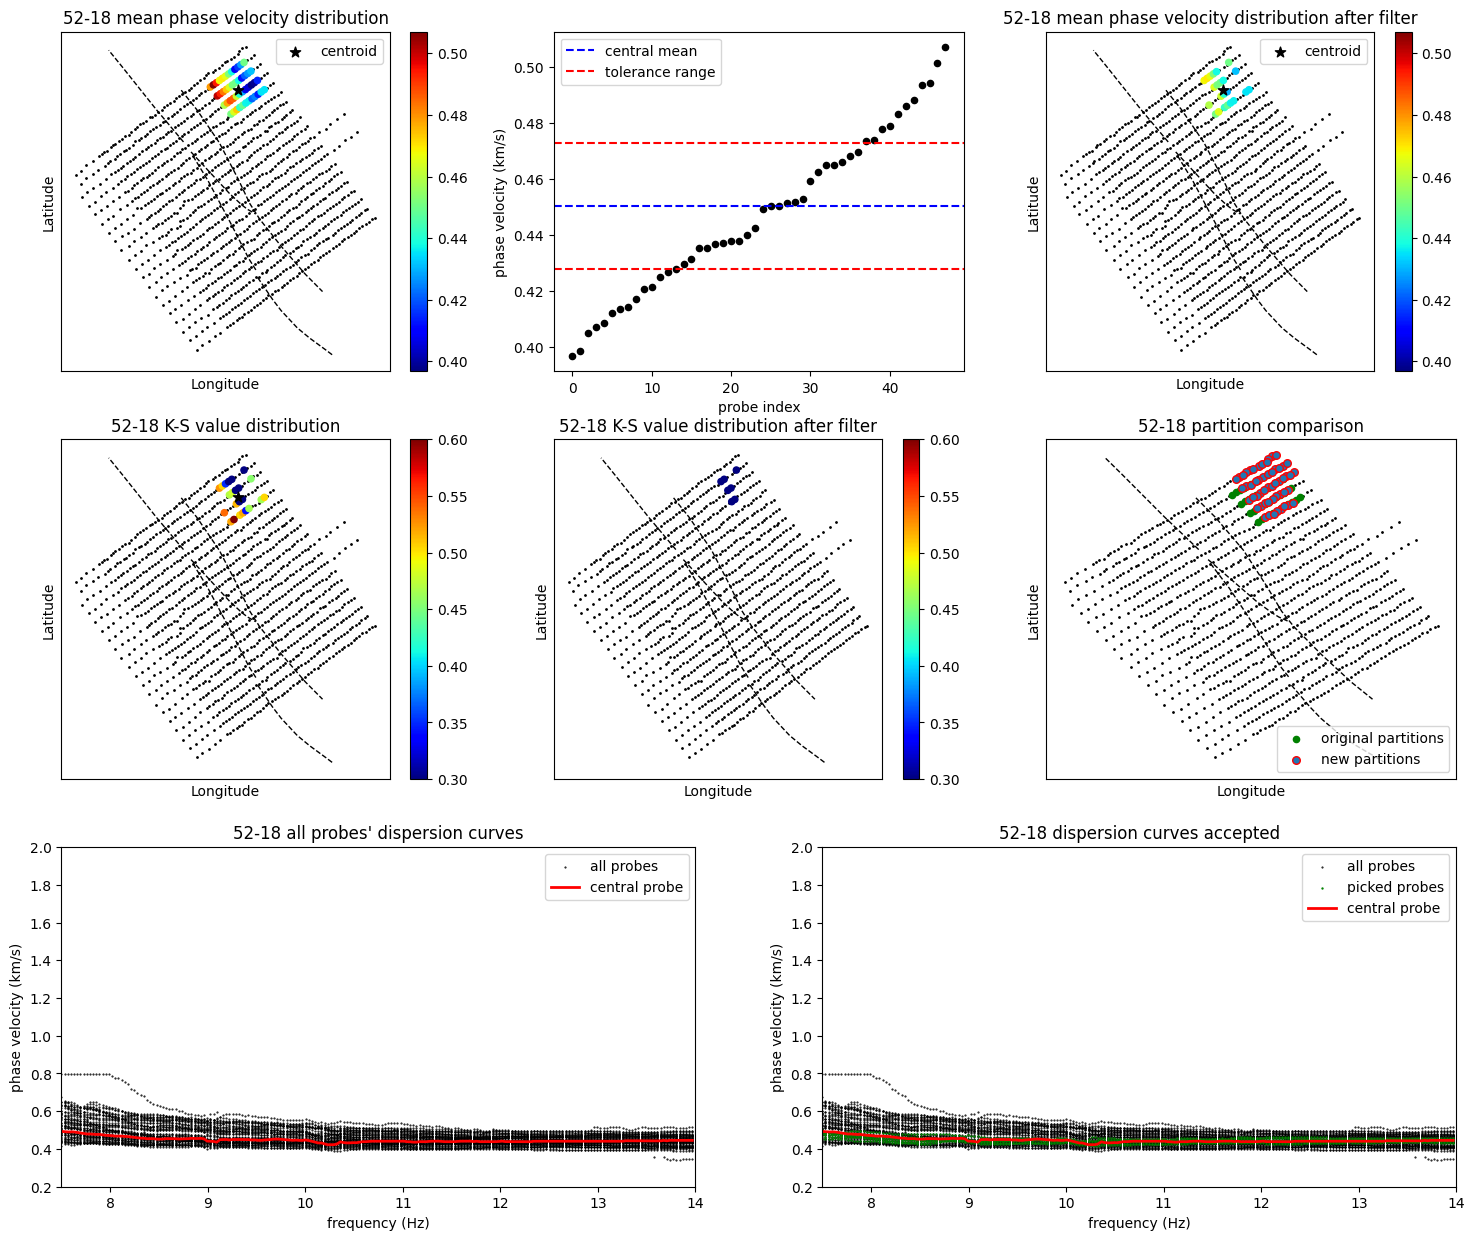

In [346]:
flag_err = 0.05
flag_pass = 0.3
flag_plot = 1
ks_f_range = [7.5,14]
flag_par = 1
nThreads = 40
probe_accept_all = {}
stations_accept_all = {}
lon_centroid_all = {}
lat_centroid_all = {}
for key_subwork in key_subworks:
    target = key_subwork.split('--')[0]
    cluster_filter(target)

In [347]:
stations_accept_all_new = {}
lon_centroid_all_new = {} 
lat_centroid_all_new = {}
for key_subwork in key_subworks:
    check_lat_lon(key_subwork)

filename_bi = dir_project+'Basic_info.npy'
info_basic_bi = np.load(filename_bi, allow_pickle='TRUE').item()      # setting dictionary

probe_accept_origin = info_basic_bi['probe_accept']
key_probe = info_basic_bi['probe']
for key_subwork in key_subworks:
    target = key_subwork.split('--')[0]
    probe_accept_origin[target] = probe_accept_all[target]
    probes_this = extract_probes(target)
    key_probe[key_subwork] = probes_this
info_basic_bi['probe_accept'] = probe_accept_origin
info_basic_bi['probe'] = key_probe

filename = dir_project+'stations_info.xlsx'
books = load_workbook(filename)
for key in key_subworks:
    df=pd.DataFrame()
    df['Station'] = list(stations_accept_all_new[key])
    df['latitude'] = [lat_all[stalist_all.index(station)] for station in stations_accept_all_new[key]]
    df['longitude'] = [lon_all[stalist_all.index(station)] for station in stations_accept_all_new[key]]
    books.create_sheet(key)
    books[key].append(['Station','latitude','longitude'])
    for i in range(len(df)):
        books[key].append(df.iloc[i,:].tolist())
books.save(filename)


filename = dir_project + 'subwork_location.xlsx'
loc_info = pd.read_excel(filename,sheet_name='location')
lat_centroid_all_origin = loc_info['lat_centroid'].tolist()
lon_centroid_all_origin = loc_info['lon_centroid'].tolist()
stations = loc_info['key_subwork'].tolist()
for key in key_subworks:
    index = stations.index(key)
    lat_centroid_all_origin[index] = lat_centroid_all_new[key]
    lon_centroid_all_origin[index] = lon_centroid_all_new[key]
loc_info['lat_centroid'] = lat_centroid_all_origin
loc_info['lon_centroid'] = lon_centroid_all_origin
writers = pd.ExcelWriter(filename, engine='openpyxl')
loc_info.to_excel(writers, sheet_name='location',index=False)
writers._save()

with open(dir_project+'Basic_info.yml', 'w', encoding='utf-8') as f:
    yaml.dump(data=info_basic, stream=f, allow_unicode=True)
np.save(dir_project + 'Basic_info.npy', info_basic_bi)

# Delete original stack and ds
dir_stack = dir_project + info_basic['dir_stack']
dir_ds = dir_project + info_basic['dir_ds']
list_stack = os.listdir(dir_stack)
list_ds = os.listdir(dir_ds)
for key in key_subworks:
    stack_this = key + '_gather_linear.h5'
    stack_timewindow = key + '_gather_timewindow.h5'
    ds_this = 'ds_'+key +'.h5'
    if stack_this in list_stack:
        print('delete ', stack_this)
        os.remove(dir_stack + stack_this)
    if stack_timewindow in list_stack:
        print('delete ', stack_timewindow)
        os.remove(dir_stack + stack_timewindow)
    if ds_this in list_ds:
        print('delete ', ds_this)
        os.remove(dir_ds + ds_this)

delete  52-18--681_gather_linear.h5
delete  52-18--681_gather_timewindow.h5
delete  ds_52-18--681.h5
